Importing Libraries

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

In [36]:
pumpkins = pd.read_csv('./data/US-pumpkins.csv')
pumpkins.head()

,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


In [37]:
#Check if there is missing data in the current dataframe
pumpkins.isnull().sum()

City Name             0
Type               1712
Package               0
Variety               5
Sub Variety        1461
Grade              1757
Date                  0
Low Price             0
High Price            0
Mostly Low          103
Mostly High         103
Origin                3
Origin District    1626
Item Size           279
Color               616
Environment        1757
Unit of Sale       1595
Quality            1757
Condition          1757
Appearance         1757
Storage            1757
Crop               1757
Repack                0
Trans Mode         1757
Unnamed: 24        1757
Unnamed: 25        1654
dtype: int64

In [39]:
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

new_columns = ['Package', 'Variety', 'City Name', 'Month', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.drop([c for c in pumpkins.columns if c not in new_columns], axis=1)

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()

C:\Users\PC\AppData\Local\Temp\ipykernel_7532\3582767433.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)


,Month,DayOfYear,Variety,City,Package,Low Price,High Price,Price
70,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364
71,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
72,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
73,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,17.0,17.0,15.454545
74,10,281,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364


<Axes: xlabel='Month', ylabel='Price'>

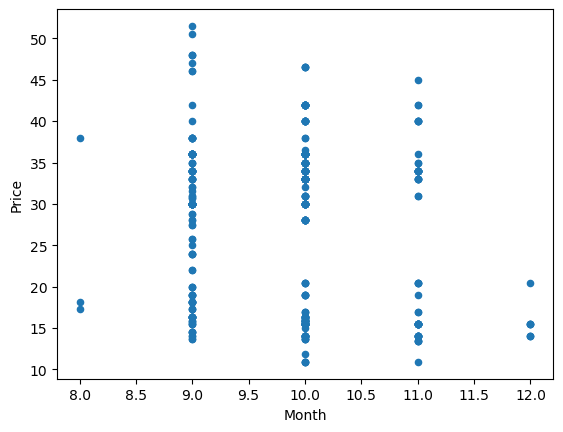

In [40]:
#Visualize using scatter
new_pumpkins.plot.scatter('Month','Price')

<Axes: xlabel='DayOfYear', ylabel='Price'>

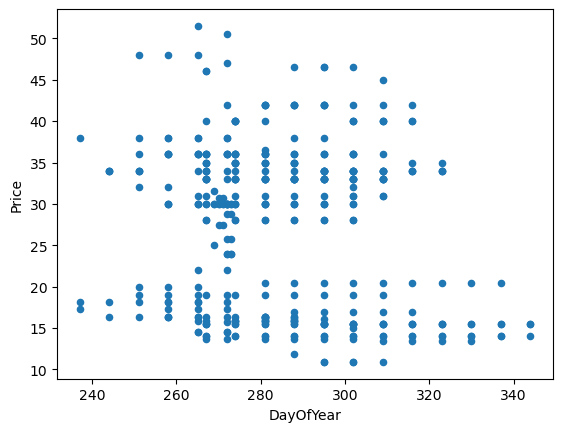

In [41]:
new_pumpkins.plot.scatter('DayOfYear','Price')

Check for correlation

In [42]:
print(new_pumpkins['Month'].corr(new_pumpkins['Price']))
print(new_pumpkins['DayOfYear'].corr(new_pumpkins['Price']))

-0.14878293554077537
-0.16673322492745402


Visualize different pumpkins varieties

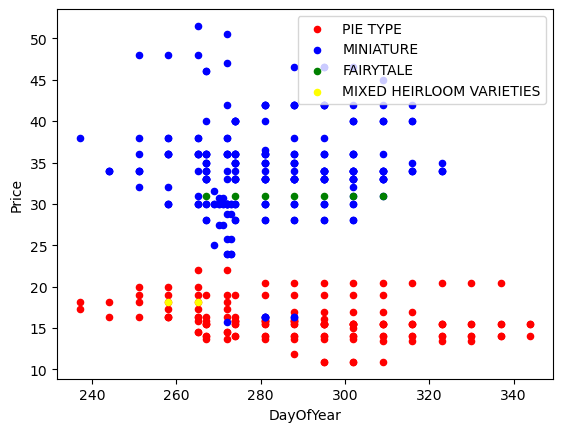

In [43]:
ax=None
colors = ['red','blue','green','yellow']
for i,var in enumerate(new_pumpkins['Variety'].unique()):
    ax = new_pumpkins[new_pumpkins['Variety']==var].plot.scatter('DayOfYear','Price',ax=ax,c=colors[i],label=var)

<Axes: xlabel='Variety'>

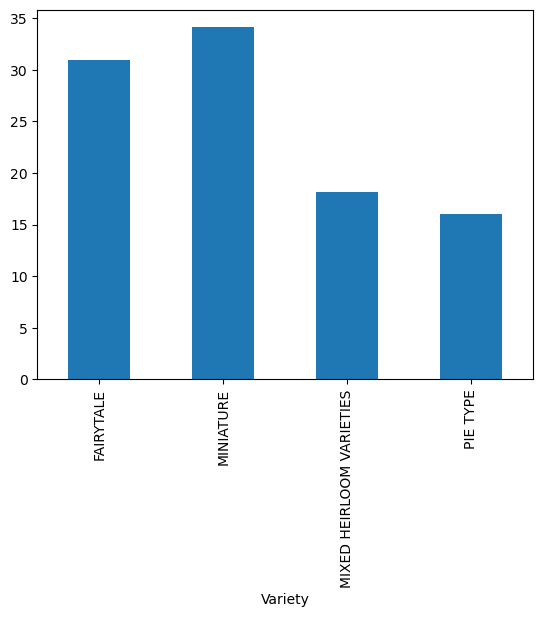

In [45]:
new_pumpkins.groupby('Variety')['Price'].mean().plot(kind='bar')

Using one variety-  Pie Type

-0.2669192282197318


<Axes: xlabel='DayOfYear', ylabel='Price'>

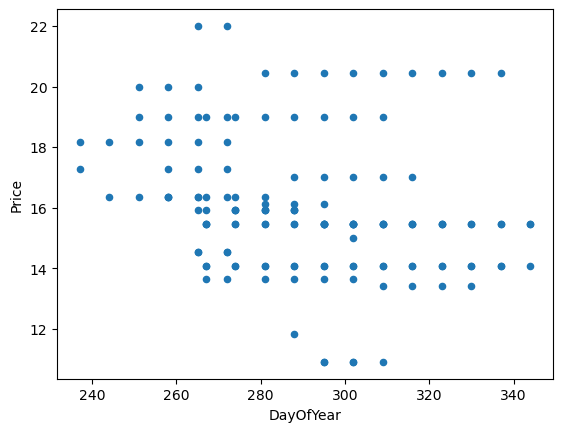

In [46]:
pie_pumpkins = new_pumpkins[new_pumpkins['Variety']=='PIE TYPE']
print(pie_pumpkins['DayOfYear'].corr(pie_pumpkins['Price']))
pie_pumpkins.plot.scatter('DayOfYear','Price')

Linear Regression

In [48]:
#Import Scikit libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [49]:
X = pie_pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
y = pie_pumpkins['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

pred = lin_reg.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

Mean error: 2.77 (17.2%)


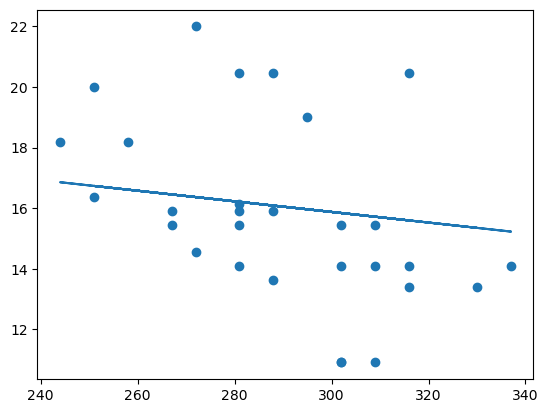

In [50]:
plt.scatter(X_test,y_test)
plt.plot(X_test,pred)

In [51]:
lin_reg.coef_, lin_reg.intercept_

(array([-0.01751876]), 21.133734359909326)

In [53]:
#Use train model to predict price
lin_reg.predict([[260]])

array([16.57885651])

Logistic Regression

In [58]:
#load data
full_pumpkins = pd.read_csv('./data/US-pumpkins.csv')
full_pumpkins.head()


,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


In [62]:
# Select the columns we want to use
columns_to_select = ['City Name','Package','Variety', 'Origin','Item Size', 'Color']
new_Pumpkins = full_pumpkins.loc[:, columns_to_select]

# Drop rows with missing values
new_Pumpkins.dropna(inplace=True)

new_Pumpkins.head()

,City Name,Package,Variety,Origin,Item Size,Color
2,BALTIMORE,24 inch bins,HOWDEN TYPE,DELAWARE,med,ORANGE
3,BALTIMORE,24 inch bins,HOWDEN TYPE,VIRGINIA,med,ORANGE
4,BALTIMORE,24 inch bins,HOWDEN TYPE,MARYLAND,lge,ORANGE
5,BALTIMORE,24 inch bins,HOWDEN TYPE,MARYLAND,lge,ORANGE
6,BALTIMORE,36 inch bins,HOWDEN TYPE,MARYLAND,med,ORANGE


Visualize the Data with seaborn

c:\Users\PC\miniconda3\envs\datascience\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


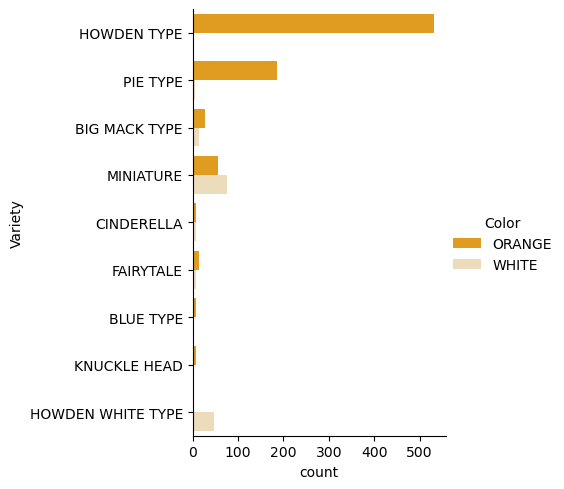

In [63]:
# Specify colors for each values of the hue variable
palette = {
    'ORANGE': 'orange',
    'WHITE': 'wheat',
}
# Plot a bar plot to visualize how many pumpkins of each variety are orange or white
sns.catplot(
    data=new_Pumpkins, y="Variety", hue="Color", kind="count",
    palette=palette, 
)

Data pre-processing
encode features and labels to better plot the data and train the model

In [64]:
# Let's look at the different values of the 'Item Size' column
new_Pumpkins['Item Size'].unique()

array(['med', 'lge', 'sml', 'xlge', 'med-lge', 'jbo', 'exjbo'],
      dtype=object)

In [65]:
from sklearn.preprocessing import OrdinalEncoder
# Encode the 'Item Size' column using ordinal encoding
item_size_categories = [['sml', 'med', 'med-lge', 'lge', 'xlge', 'jbo', 'exjbo']]
ordinal_features = ['Item Size']
ordinal_encoder = OrdinalEncoder(categories=item_size_categories)

In [66]:
from sklearn.preprocessing import OneHotEncoder
# Encode all the other features using one-hot encoding
categorical_features = ['City Name', 'Package', 'Variety', 'Origin']
categorical_encoder = OneHotEncoder(sparse_output=False)

In [68]:
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer(transformers=[
     ('ord', ordinal_encoder, ordinal_features),
     ('cat', categorical_encoder, categorical_features)
     ])
# Get the encoded features as a pandas DataFrame
ct.set_output(transform='pandas')
encoded_features = ct.fit_transform(new_Pumpkins)
encoded_features.head()

,ord__Item Size,cat__City Name_ATLANTA,cat__City Name_BALTIMORE,cat__City Name_BOSTON,cat__City Name_CHICAGO,cat__City Name_COLUMBIA,cat__City Name_DALLAS,cat__City Name_DETROIT,cat__City Name_LOS ANGELES,cat__City Name_MIAMI,...,cat__Origin_MICHIGAN,cat__Origin_NEW JERSEY,cat__Origin_NEW YORK,cat__Origin_NORTH CAROLINA,cat__Origin_OHIO,cat__Origin_PENNSYLVANIA,cat__Origin_TENNESSEE,cat__Origin_TEXAS,cat__Origin_VERMONT,cat__Origin_VIRGINIA
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
from sklearn.preprocessing import LabelEncoder
# Encode the 'Color' column using label encoding
label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(new_Pumpkins['Color'])
encoded_pumpkins = encoded_features.assign(Color=encoded_label)
encoded_pumpkins.head()

,ord__Item Size,cat__City Name_ATLANTA,cat__City Name_BALTIMORE,cat__City Name_BOSTON,cat__City Name_CHICAGO,cat__City Name_COLUMBIA,cat__City Name_DALLAS,cat__City Name_DETROIT,cat__City Name_LOS ANGELES,cat__City Name_MIAMI,...,cat__Origin_NEW JERSEY,cat__Origin_NEW YORK,cat__Origin_NORTH CAROLINA,cat__Origin_OHIO,cat__Origin_PENNSYLVANIA,cat__Origin_TENNESSEE,cat__Origin_TEXAS,cat__Origin_VERMONT,cat__Origin_VIRGINIA,Color
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [71]:
# Let's look at the mapping between the encoded values and the original values
list(label_encoder.inverse_transform([0, 1]))

['ORANGE', 'WHITE']

Analysing relationships between features and label

c:\Users\PC\miniconda3\envs\datascience\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


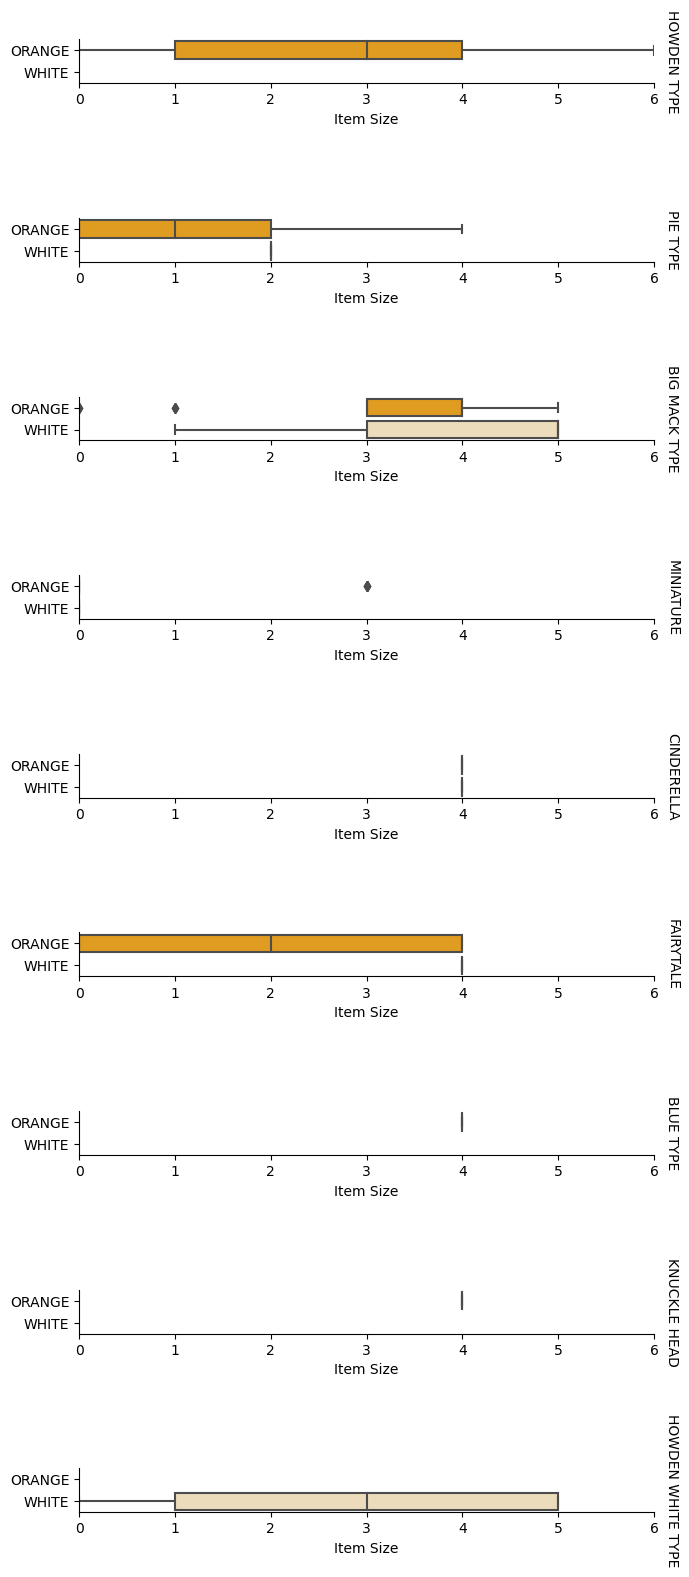

In [74]:
palette = {
    'ORANGE': 'orange',
    'WHITE': 'wheat',
}
# We need the encoded Item Size column to use it as the x-axis values in the plot
new_Pumpkins['Item Size'] = encoded_pumpkins['ord__Item Size']

g = sns.catplot(
    data=new_Pumpkins,
    x="Item Size", y="Color", row='Variety',
    kind="box", orient="h",
    sharex=False, margin_titles=True,
    height=1.8, aspect=4, palette=palette,
)
# Defining axis labels 
g.set(xlabel="Item Size", ylabel="").set(xlim=(0,6))
g.set_titles(row_template="{row_name}")

In [75]:
#focusing on a specific relationship: Item Size and Color!
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='seaborn')

<Axes: xlabel='Color', ylabel='ord__Item Size'>

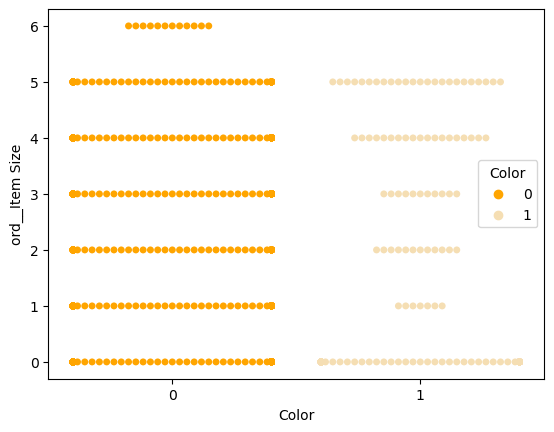

In [76]:
# Suppressing warning message claiming that a portion of points cannot be placed into the plot due to the high number of data points
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='seaborn')

palette = {
    0: 'orange',
    1: 'wheat'
}
sns.swarmplot(x="Color", y="ord__Item Size", hue="Color", data=encoded_pumpkins, palette=palette)

Build your model

In [78]:
from sklearn.model_selection import train_test_split
# X is the encoded features
X = encoded_pumpkins[encoded_pumpkins.columns.difference(['Color'])]
# y is the encoded label
y = encoded_pumpkins['Color']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [79]:
from sklearn.metrics import f1_score, classification_report 
from sklearn.linear_model import LogisticRegression

# Train a logistic regression model on the pumpkin dataset
model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Evaluate the model and print the results
print(classification_report(y_test, predictions))
print('Predicted labels: ', predictions)
print('F1-score: ', f1_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       166
           1       0.85      0.67      0.75        33

    accuracy                           0.92       199
   macro avg       0.89      0.82      0.85       199
weighted avg       0.92      0.92      0.92       199

Predicted labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 1 1]
F1-score:  0.7457627118644068


In [80]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[162,   4],
       [ 11,  22]], dtype=int64)

Visualize the ROC curve of this model

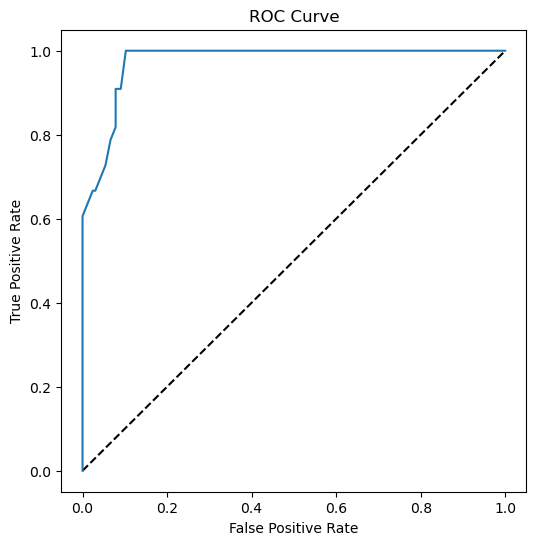

In [81]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

y_scores = model.predict_proba(X_test)
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [82]:
# Calculate AUC score
auc = roc_auc_score(y_test,y_scores[:,1])
print(auc)

0.9749908725812341
